## Autoencoders


Material adapted from: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb

Code licensed under https://www.apache.org/licenses/LICENSE-2.0




An autoencoder is a special type of neural network that is trained to copy its input to its output. 

For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. An AE is made up of:

* encoder
* decoder

The encoder takes in the input and compresses the input into a latent space represtation which is smaller than the input.

The decoder takes the latent vector and upsamples the data to match the input shape.

An autoencoder has two main parts: an encoder that maps the message to a code, and a decoder that reconstructs the message from the code. An optimal autoencoder would perform as close to perfect reconstruction as possible, with "close to perfect" defined by the reconstruction quality function d.

Common applications:

* data compression
* medical denoising of images
* enhancing OCR

![](https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png)

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

### Download the data

This is an unsupervised problem so we don't need the labels

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


### Normalise the data

Divide by the maximum pixel value, 255.

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
x_train.shape

(60000, 28, 28)

### Reshape the data so that it has a 1 to indicate the depth of each image

In [ ]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [ ]:
x_train.shape

(60000, 28, 28, 1)

Instead of working on the class directly like in the last prac, let's build the encoder and decoded using the functional API separately to make sure we get the shapes correct.

### Encoder

Here we want to input an image of (28,28,1) and output a shape of (16) which is the encoded image.

So we need to build an appropriate architecture which will produce that output.



In [ ]:
# Here we use the Functional API which requires 3 things (Input, model and output)

# Specify the input layer here a shape of 28x28x1 (greyscale images)
encoder_input = tf.keras.Input(shape=(28, 28, 1))
print(encoder_input.shape)

# First conv layer which will reduce the shape by half given a stride of 2
encoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(encoder_input)
print(encoder.shape)
# Second conv layer which will reduce the shape by half given a stride of 2
encoder = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(encoder)
print(encoder.shape)
# Get the size of the current tensor - this will help us re-create this size when we create the decoder
# This will make more sense below.
tensor_shape = K.int_shape(encoder)

# Flatten
encoder = tf.keras.layers.Flatten()(encoder)
print(encoder.shape)
# Output layer has units based on latent dimension - here 16.
encoder_output = tf.keras.layers.Dense(16, activation = 'linear')(encoder)
print(encoder_output.shape)

Take note of the shape before we flatten to the latest space vector. This will become handy when we try do the reverse operations in terms of upsampling.

Also note the compression achieved here, from 28x28 images (784 pixels) to only 16 values!

In [ ]:
tensor_shape

(None, 7, 7, 8)

In [ ]:
# Create a Model and specify the input and output
# This is normal Keras functional API like in the ANN prac
model = tf.keras.Model(encoder_input, encoder_output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 16)                6288      
                                                                 
Total params: 7,608
Trainable params: 7,608
Non-trainable params: 0
_________________________________________________________________


here we see that we saved the volume as (7,7,8). In the encoder, we go from (7,7,8) which is 392 pixels to 16. So when we create the decoder, essentially we will go from 16 to 392 to (7,7,8). 

By saving this we can obtain two things: 

* the shape of 392, i.e. no hard-coding of values

* the shape (7,7,8), i.e. again no hard-coding. We can do so without manually knowing these value and having to manually input them. See below from the two cells.

In [ ]:
tensor_shape

(None, 7, 7, 8)

In [ ]:
np.prod(tensor_shape[1:])

392

### Decoder

Here we want to input a shape of (16) and output an image of (28,28,1) which is the decoded image.

So we need to build an appropriate architecture which will produce that output.

The decoder is essentially the inverse of the encoder.

In [ ]:
# Here we use the Functional API which requires 3 things (Input, model and output)

# Specify the input layer here a shape of (16) (encoded images)
decoder_input = tf.keras.Input(shape=(16,))

# Now we create our first dense layer which will go from 16 -> 392. But we don't need to manually
# enter the value of 392 since we have a way to automatically calculate this (see above)
decoder = tf.keras.layers.Dense(np.prod(tensor_shape[1:]), activation = 'linear')(decoder_input)

# If we look at the encoder, the step before 392 unit layer was a tensor of shape (7,7,8). Again
# we don't have to manually enter these values. So here we reshape the vector to get a tensor of
# shape (7,7,8)
decoder = tf.keras.layers.Reshape((tensor_shape[1], tensor_shape[2], tensor_shape[3]))(decoder)

# Working backwards, we can to the opposite of Conv2D which is Transpose convolution. 
# API https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose
decoder = layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(decoder)

decoder = layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(decoder)

# At this point our shape is (28,28,16) but we want (28,28,1) so we can remove the 16 features by
# applying a convolutional layer with 1 filter.
decoder_output = layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(decoder)

In [ ]:
model = tf.keras.Model(decoder_input, decoder_output)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 392)               6664      
                                                                 
 reshape (Reshape)           (None, 7, 7, 8)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145 

Now, let's take everything above and create our own Model object as a Python class which will inheret from the Model object. Thus we need to override the `__init__ `function and `call` function.

In [ ]:
# Define the latent dimension
latent_dim = 16

class Autoencoder(Model):
  def __init__(self, latent_dim, name="autoencoder"):
    super(Autoencoder, self).__init__()

    # The latent dimension is a property of an autoencoder
    self.latent_dim = latent_dim  

    # The Autoencoder has an encoder which we can make using normal layers
    # Here we use the Functional API which requires 3 things (Input, model and output)
    # ------------------------------------------
    # Specify the input layer here a shape of 28x28x1 (greyscale images)
    self.encoder_input = tf.keras.Input(shape=(28, 28, 1))
    self.encoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(self.encoder_input)
    self.encoder = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(self.encoder)

    # Get this size
    volumeSize = K.int_shape(self.encoder)

    # Flatten
    self.encoder = tf.keras.layers.Flatten()(self.encoder)

    # Output
    self.encoder_output = tf.keras.layers.Dense(latent_dim, activation = 'linear')(self.encoder)

    self.encoder_model = tf.keras.Model(self.encoder_input, self.encoder_output)
    # ------------------------------------------

    # The Autoencoder has an decoder  which we can make using normal layers
    # Here we use the Functional API which requires 3 things (Input, model and output)
    # ------------------------------------------

    self.decoder_input = tf.keras.Input(shape=(latent_dim,))

    self.decoder = tf.keras.layers.Dense(np.prod(tensor_shape[1:]), activation = 'linear')(self.decoder_input)

    self.decoder = tf.keras.layers.Reshape((tensor_shape[1], tensor_shape[2], tensor_shape[3]))(self.decoder)

    self.decoder = layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(self.decoder)

    self.decoder = layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(self.decoder)

    self.decoder_output = layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(self.decoder)

    self.decoder_model = tf.keras.Model(self.decoder_input, self.decoder_output)
    # ------------------------------------------

  # The forward pass
  def call(self, x):

    # Encode the inputs x using the propery defined above
    # In the previous notebook we created the encoder and decoder as Sequential Models
    # but now since we used the Functional API we need to call the Model objects we created above
    encoded = self.encoder_model(x)

    # Decode the encoded vector using the property defined above
    decoded = self.decoder_model(encoded)

    # Return the decoded (28,28) data
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
1875/1875 [==============================] - 21s 4ms/step - loss: 0.0316 - val_loss: 0.0164
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0156 - val_loss: 0.0143
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0128 - val_loss: 0.0122


In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 16)                7608      
                                                                 
 model_3 (Functional)        (None, 28, 28, 1)         8561      
                                                                 
Total params: 16,169
Trainable params: 16,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Let's view a test example
x_test[0,:,:,0].shape

(28, 28)

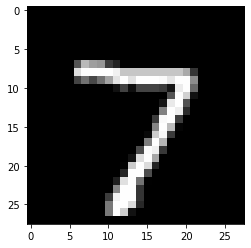

In [ ]:
# Let's view a test example
plt.imshow(x_test[0,:,:,0])
plt.gray()

In [ ]:
# Encode the testing example
encoded_img = autoencoder.encoder_model(np.expand_dims(x_test[0],0)).numpy()

In [ ]:
encoded_img

array([[-3.302598  ,  7.078636  ,  0.5563028 ,  2.7324147 , -3.58512   ,
         6.7053113 , -4.7408695 , -4.431025  , -0.07351862, -2.3180866 ,
        -1.7459167 , -7.693223  , -0.7297868 , -2.7880156 , -1.3355354 ,
        -0.6244915 ]], dtype=float32)

In [ ]:
# 16 values!
encoded_img.shape

(1, 16)

In [ ]:
# Now take those 16 values and reconstruct the input
# i.e. we will go from 16 values to 784 values
decoded_img = autoencoder.decoder_model(encoded_img).numpy()

In [ ]:
decoded_img.shape

(1, 28, 28, 1)

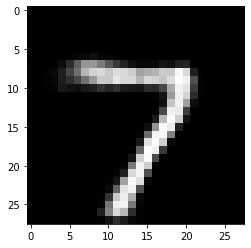

In [ ]:
plt.imshow(decoded_img[0,:,:,0])
plt.gray()

## Now let's compare the original images to the recontructed images on all of the testing data

In [ ]:
encoded_imgs = autoencoder.encoder_model(x_test).numpy()
decoded_imgs = autoencoder.decoder_model(encoded_imgs).numpy()

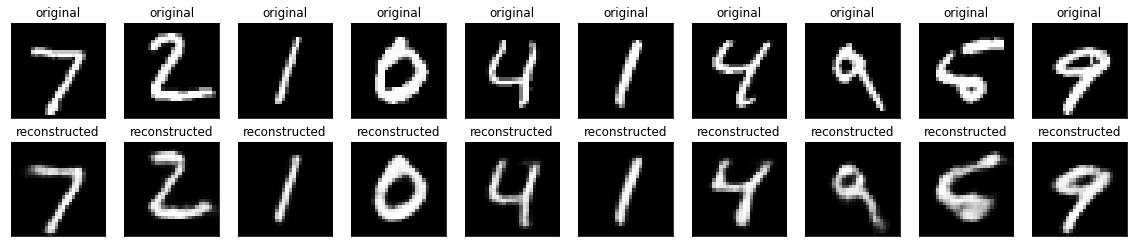

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i,:,:,0])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i,:,:,0])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Task:

* Explore modifications to the encoder and decoder (i.e. different conv layers in the encoder and decover).

* Try different values for the latent dimensions

* What is the best compression you can achieve?

